In [1]:
import os
import os.path as osp
import json
from argparse import ArgumentParser
from glob import glob

import torch
import cv2
from torch import cuda
from model import EAST
from tqdm import tqdm

from detect import detect

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PIL import Image, ImageOps

In [10]:
data_dir = '../input/data/AIhub/images/'
input_size = 512

In [11]:
model = EAST(pretrained=False).to('cuda')
weights = './latest_ICDAR2017ko_upstagereanno_200epoch.pth'
model.load_state_dict(torch.load(weights, map_location='cpu'))

<All keys matched successfully>

In [12]:
model.eval()
image_fnames, by_sample_bboxes = [], []
images = []

for image_fpath in tqdm(glob(osp.join(data_dir, '*'))):

    image_fnames.append(osp.basename(image_fpath))
    
    images.append(cv2.imread(image_fpath)[:, :, ::-1])
    if len(images) == 20:
        by_sample_bboxes.extend(detect(model, images, input_size))
        images = []

if len(images):
    by_sample_bboxes.extend(detect(model, images, input_size))

ufo_result = dict(images=dict())
for image_fname, bboxes in zip(image_fnames, by_sample_bboxes):
    words_info = {idx: dict(points=bbox.tolist()) for idx, bbox in enumerate(bboxes)}
    ufo_result['images'][image_fname] = dict(words=words_info)

  2%|▏         | 19/900 [00:02<02:00,  7.32it/s]


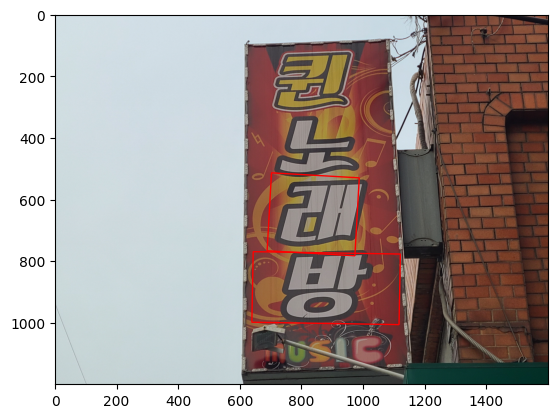

In [18]:
idx = 1
img =   plt.imread(data_dir+image_fnames[idx])

fig, ax = plt.subplots()
ax.imshow(img)

for i in range(len(by_sample_bboxes[idx])):
    dots = by_sample_bboxes[idx][i]
    ax.add_patch(patches.Polygon(dots, edgecolor='r', facecolor='none'))
